# CE597 - Mapping Projection and Geometric Geodesy

## Lab 08 - Mapping The Shortest (Geodesic) Distance

*Kevan Tissue*  
*Geomatics Engineering*  
*Lyles School of Civil Engineering*  
*Purdue University*

________

# <span style="color:green">*PART 0 - Initialization, Functions, Data Preparation, & Calculations*<span>

In Lab 3, 4, 5, and 6, we employed various mapping prescription which are defined on the Cartesian coordinate frame. In this lab, we will create different maps using stereographic mapping prescriptions which are defined in the Polar coordinate frame.

## $\blacktriangleright$  <span style="color:limegreen">*Initialization*<span>

**Importing the necessary packages**

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot figures inside the notebook
%matplotlib inline

**Formula for conversing to radians**

In [2]:
rad = math.pi/180
deg = 180/math.pi

**Earth's Radius**  
*(Assuming that the Earth is sphere and the radius of the Earth is 6371 km)*

In [3]:
R = 6371000 # meters

------

## $\blacktriangleright$ <span style="color:limegreen">*Functions*<span>

**DMS $\rightarrow$ Decimal Degrees**

In [4]:
def dms2dd(dd, mm, ss):
    """
    A function that will convert degree minute second (DMS) format into decimal degree format
    
    Inputs
    -----
    dd: spherical coordinate value: degrees (integer)
    mm:spherical coordinate value: minutes (integer)
    ss: spherical coordinate value: seconds (floating number)
    
    Output
    ------
    calculated decimal degree value (floating number)
    """
    return dd + mm/60 + ss/3600

**Decimal Degrees $\rightarrow$ DMS**

In [5]:
def dd2dms(dec_deg):
    """
    A function that will convert decimal degree format into degree minute second (DMS) format 
    
    Inputs
    -----
    decimal degree value (floating number)
    
    Output
    ------
    dd: spherical coordinate value: degrees (integer)
    mm:spherical coordinate value: minutes (integer)
    ss: spherical coordinate value: seconds (floating number)
    """
    
    dd = int(dec_deg)
    mmfloat = (dec_deg - dd) * 60
    mm = int(mmfloat)
    ss = (mmfloat - mm) * 60
    
    return dd, mm, ss

**Spherical $\rightarrow$ Cartesian**

In [6]:
def sph2xyz(l,p,h, R = 6371000):
    """
    Function that converts geocentric earth-fixed spherical coordinates 
    into geocentric earth-fixed cartesian coordinates
    
    Input
    -----
    l: lambda, longitude (units: radians)
    p: psi, latitude (units: radians)
    h: height above sphere (units: meters)
    
    Output
    ------
    x,y,z: cartesian coordinates (units: meters)
    """
    x = (R+h) * np.cos(p) * np.cos(l)
    y = (R+h) * np.cos(p) * np.sin(l)
    z = (R+h) * np.sin(p)
    
    return x,y,z

**Cartesian $\rightarrow$ Spherical**

In [7]:
def xyz2sph(x,y,z, R = 6371000):
    """
    Function that converts geocentric earth-fixed cartesian coordinates into 
    geocentric earth-fixed spherical coordinates
    
    Input
    -----
    x,y,z: cartesian coordinates (units: meters)
    
    Output
    ------
    lmd: longitude (units: radians)
    psi: latitude (units: radians)
    h: height above sphere (units: meters)
    """
    lmd = np.arctan2(y, x) * deg
    psi = np.arctan2(z, math.sqrt(x**2 + y**2)) * deg
    h = math.sqrt(x**2 + y**2 + z**2) - R
    
    return lmd, psi, h

**Stereographic Mapping Prescription**

In [8]:
def stereo(df, big):
    """
    A function that will take a data frame containing coordinates in decimal degrees
    and apply a stereographic mapping prescription to it
    
    Input
    -----
    pandas.DataFrame with columns: psi, lambda (no prescription)
    big: whether map needs to extend beyond 115 degrees or not. (1 = yes, 0 = no)
    
    Output
    ------
    pandas.DataFrame with columns: psi, lambda (mercator prescription)
    """
 
    if big == 1:
        df = df[(df['psi'] >= -50)]
    elif big == 0:
        df = df[(df['psi'] >= -15)]
            
    # resetting the data frame index
    df = df.reset_index(drop=True)
    
    # defining the colatitude for psi
    df['theta'] = np.pi/2 - df['psi']*rad
    
    # applying the stereographic mapping prescription 
    df['psi'] = (2 * np.tan(df['theta']/2) * np.sin(df['lambda']*rad)) * deg
    df['lambda'] = (2 * np.tan(df['theta']/2) * np.cos(df['lambda']*rad)) * deg
    

    return df

**Mapping Prescriptions**

In [9]:
# Setting up argument variables for function
RW = 0
PC = 1
SF = 2
MC = 3
PCt = 4
SFt = 5
MCt = 6
ST = 7
OST = 8

def prescribe(df, prescription):
    """
    Function that applies a mapping prescription to geocentric earth-fixed spherical coordinates in a data frame.
    
    Input
    -----
    dataframe: lambda, psi, height (units: decimal degrees)
    prescription: desired mapping prescription (RW, PC, SF, MC)
    
    Output
    ------
    dataframe: lambda, psi, height (units: lambda=radians, psi=radians, height=meters)
    """
    
    # Initializing Variables
    lam = np.zeros(len(df), dtype = np.float64)
    psi = np.zeros(len(df), dtype = np.float64)
    h = np.zeros(len(df), dtype = np.float64)
          
    if prescription == 3:
        df = mercator(df)        
    if prescription == 6:
        df = mercator(df)    
    if prescription == 7:
        df = stereo(df, 0)
    elif prescription ==8:
        df = stereo(df, 0)
  
    # Applying mapping prescriptions
    for index, row in df.iterrows():
        # Real World
        if prescription == 0:
            lam[index], psi[index], h[index] = [row['lambda'], 
                                                row['psi'], 
                                                row['h']]       
        
        # Plate Carree
        elif prescription == 1:
            lam[index], psi[index], h[index] = [row['lambda'], 
                                                row['psi'], 
                                                row['h']] 
        # Sanson-Flamsteed
        elif prescription == 2:
            lam[index], psi[index], h[index] = [row['lambda']*np.cos(row['psi']*rad), 
                                                row['psi'], 
                                                row['h']]
        # Mercator 
        elif prescription == 3:
            lam[index], psi[index], h[index] = [row['lambda'], 
                                                row['psi'], 
                                                row['h']] 
        # Transverse Plate Carree
        elif prescription == 4:
            lam[index], psi[index], h[index] = [row['lambda'], 
                                                row['psi'], 
                                                row['h']] 
        # Transverse Sanson-Flamsteed
        elif prescription == 5:
            lam[index], psi[index], h[index] = [row['lambda']*np.cos(row['psi']*rad), 
                                                row['psi'], 
                                                row['h']]
        # Transverse Mercator 
        elif prescription == 6:
            lam[index], psi[index], h[index] = [row['lambda'], 
                                                row['psi'], 
                                                row['h']] 
        # Stereographic
        elif prescription == 7:
            lam[index], psi[index], h[index] = [row['lambda'], 
                                                row['psi'], 
                                                row['h']]  
        # Oblique Stereographic
        elif prescription == 8:
            lam[index], psi[index], h[index] = [row['lambda'], 
                                                row['psi'], 
                                                row['h']] 

    # Putting new coordinates into a data frame       
    new_coords = pd.DataFrame({
        'lambda':lam,
        'psi':psi,
        'h':h
    })
    
    xA = new_coords['lambda'][0]
    xB = new_coords['lambda'][1]
    xC = new_coords['lambda'][2]
    xD = new_coords['lambda'][3]           
    yA = new_coords['psi'][0]
    yB = new_coords['psi'][1]
    yC = new_coords['psi'][2]
    yD = new_coords['psi'][3]

    return xA,xB,xC,xD,yA,yB,yC,yD

**Mercator Mapping Prescription**

In [10]:
def mercator(df):
    """
    A function that will take a data frame containing coordinates in decimal degrees
    and apply a mercator mapping prescription to it
    
    Input
    -----
    pandas.DataFrame with columns: psi, lambda (no prescription)
    
    Output
    ------
    pandas.DataFrame with columns: psi, lambda (mercator prescription)
    """
    
    # limiting the latitude to +/- 80 degrees (before mercator)
    df = df[(-80 <= df.psi) & (df.psi <= 81)]
    
    # resetting the data frame index
    df = df.reset_index(drop=True)
    
    # applying the mercator mapping prescription 
    df.psi = np.log(np.tan(((df.psi*rad)/2) + (math.pi/4))) * deg
    
    # limiting the latitude to +/- 80 degrees (before mercator)
    df = df[(-80 <= df.psi) & (df.psi <= 81)]
    
    # resetting the data frame index
    df = df.reset_index(drop=True)
    
    
    return df

**Rotation Matrix**

In [11]:
def rotate(x, y, z, omega, phi, kappa):
    """
    Function that applies a 3D rotation to geocentric earth-fixed cartesian coordinates 
    
    Input
    -----
    x,y,z: cartesian coordinates (units: meters)
    omega: angle of rotation with respect to the x-axis (units: decimal degrees)
    phi:   angle of rotation with respect to the y-axis (units: decimal degrees)
    kappa: angle of rotation with respect to the z-axis (units: decimal degrees)
    
    Output
    ------
    x,y,z: rotated cartesian coordinates (units: meters)
    """
    # Initializing Variables
    xp = np.zeros(x.shape[0])
    yp = np.zeros(y.shape[0])
    zp = np.zeros(z.shape[0])
    
    # Converting the angles from decimal degrees to radians
    ax = omega * rad
    ay = phi * rad
    az = kappa * rad
    
    # Rotation matrices for each axis
    Rx = [[1, 0, 0],
         [0, np.cos(ax), np.sin(ax)],
         [0, -np.sin(ax), np.cos(ax)]]
    
    Ry = [[np.cos(ay), 0, -np.sin(ay)],
         [0, 1, 0],
         [np.sin(ay), 0, np.cos(ay)]]
    
    Rz = [[np.cos(az), np.sin(az), 0],
         [-np.sin(az), np.cos(az), 0],
         [0, 0, 1]]
    
    # Combining the rotation matrices for each axis into a single, 3D rotation matrix
    Mxy = np.matmul(Ry,Rx)
    M = np.matmul(Rz,Mxy)
    
    # Applying rotation to cartesian coordinates (iteratively)
    for index in range(x.shape[0]):
        xp[index], yp[index], zp[index] = np.matmul(M,[x[index], y[index], z[index]])
 
    # Creating a pandas data frame of the rotated cartesian coordinates
    rotated_xyz = pd.DataFrame({
        'x': xp,
        'y': yp,
        'z': zp
    })
    
    return rotated_xyz

**Oblique Rotation Matrix**

In [12]:
def oblique_rotate(x, y, z, omega, phi, kappa):
    """
    Function that applies a 3D rotation to geocentric earth-fixed cartesian coordinates 
    
    Input
    -----
    x,y,z: cartesian coordinates (units: meters)
    omega: angle of rotation with respect to the x-axis (units: decimal degrees)
    phi:   angle of rotation with respect to the y-axis (units: decimal degrees)
    kappa: angle of rotation with respect to the z-axis (units: decimal degrees)
    
    Output
    ------
    x,y,z: rotated cartesian coordinates (units: meters)
    """
    # Initializing Variables
    xp = np.zeros(x.shape[0])
    yp = np.zeros(y.shape[0])
    zp = np.zeros(z.shape[0])
    
    # Converting the angles from decimal degrees to radians
    ax = omega * rad
    ay = phi * rad
    az = kappa * rad
    
    # Rotation matrices for each axis
    Rx = [[1, 0, 0],
         [0, np.cos(ax), np.sin(ax)],
         [0, -np.sin(ax), np.cos(ax)]]
    
    Ry = [[np.cos(ay), 0, -np.sin(ay)],
         [0, 1, 0],
         [np.sin(ay), 0, np.cos(ay)]]
    
    Rz = [[np.cos(az), np.sin(az), 0],
         [-np.sin(az), np.cos(az), 0],
         [0, 0, 1]]
    
    # Combining the rotation matrices for each axis into a single, 3D rotation matrix
    Mzy = np.matmul(Ry,Rz)
    M = np.matmul(Rx,Mzy)
    
    # Applying rotation to cartesian coordinates (iteratively)
    for index in range(x.shape[0]):
        xp[index], yp[index], zp[index] = np.matmul(M,[x[index], y[index], z[index]])
 
    # Creating a pandas data frame of the rotated cartesian coordinates
    rotated_xyz = pd.DataFrame({
        'x': xp,
        'y': yp,
        'z': zp
    })
    
    return rotated_xyz

**Transverse Aspect**

In [13]:
def transverse(df_sph, omega, phi, kappa):
    """
    Function that takes a data frame of spherical coordinates in the normal aspect, converts them 
    to cartesian coordinates, applies a 3D rotation, then converts them back to spherical coordinates.
    
    Input
    -----
    df_sph: data frame containing (lambda, psi, height) in spherical coordinates (units: decimal degrees)
    omega: angle of rotation with respect to the x-axis (units: decimal degrees)
    phi:   angle of rotation with respect to the y-axis (units: decimal degrees)
    kappa: angle of rotation with respect to the z-axis (units: decimal degrees)
    
    Output
    ------
    sph_new: spherical coordinates in transverse aspect (units: decimal degrees)
    """
    # Initializing Variables
    x = np.zeros(len(df_sph), dtype = np.float64)
    y = np.zeros(len(df_sph), dtype = np.float64)
    z = np.zeros(len(df_sph), dtype = np.float64)
    lam = np.zeros(len(df_sph), dtype = np.float64)
    psi = np.zeros(len(df_sph), dtype = np.float64)
    h = np.zeros(len(df_sph), dtype = np.float64)
    
    # Converting coordinates from spherical to cartesian
    for index, row in df_sph.iterrows():
        x[index], y[index], z[index] = sph2xyz(row['lambda']*rad, row['psi']*rad, row['h'])
    
    # Putting cartesian coordinates into a data frame
    xyz = pd.DataFrame({
            'x': x,
            'y': y,
            'z': z
    })

    # Applying rotation to cartesian coordinates
    xyz_new = rotate(xyz['x'], xyz['y'], xyz['z'], omega, phi, kappa) 

    # Converting the rotated coordinates from spherical to cartesian
    for index, row in xyz_new.iterrows():
        lam[index], psi[index], h[index] = xyz2sph(row['x'], row['y'], row['z'])
    
    # Putting rotated spherical coordinates into a data frame
    sph_new = pd.DataFrame({
            'lambda': lam,
            'psi': psi,
            'h': h
    })
    
    return sph_new

**Oblique Aspect**

In [14]:
def oblique(df_sph, omega, phi, kappa):
    """
    Function that takes a data frame of spherical coordinates in the normal aspect, converts them 
    to cartesian coordinates, applies a 3D rotation, then converts them back to spherical coordinates.
    
    Input
    -----
    df_sph: data frame containing (lambda, psi, height) in spherical coordinates (units: decimal degrees)
    omega: angle of rotation with respect to the x-axis (units: decimal degrees)
    phi:   angle of rotation with respect to the y-axis (units: decimal degrees)
    kappa: angle of rotation with respect to the z-axis (units: decimal degrees)
    
    Output
    ------
    sph_new: spherical coordinates in oblique aspect (units: decimal degrees)
    """
    # Initializing Variables
    x = np.zeros(len(df_sph), dtype = np.float64)
    y = np.zeros(len(df_sph), dtype = np.float64)
    z = np.zeros(len(df_sph), dtype = np.float64)
    lam = np.zeros(len(df_sph), dtype = np.float64)
    psi = np.zeros(len(df_sph), dtype = np.float64)
    h = np.zeros(len(df_sph), dtype = np.float64)
    
    # Converting coordinates from spherical to cartesian
    for index, row in df_sph.iterrows():
        x[index], y[index], z[index] = sph2xyz(row['lambda']*rad, row['psi']*rad, row['h'])
    
    # Putting cartesian coordinates into a data frame
    xyz = pd.DataFrame({
            'x': x,
            'y': y,
            'z': z
    })

    # Applying rotation to cartesian coordinates
    xyz_new = oblique_rotate(xyz['x'], xyz['y'], xyz['z'], omega, phi, kappa) 

    # Converting the rotated coordinates from spherical to cartesian
    for index, row in xyz_new.iterrows():
        lam[index], psi[index], h[index] = xyz2sph(row['x'], row['y'], row['z'])
    
    # Putting rotated spherical coordinates into a data frame
    sph_new = pd.DataFrame({
            'lambda': lam,
            'psi': psi,
            'h': h
    })
    
    return sph_new

------

# <span style="color:blue">*PART 1 - Places of Birth (Spherical Coordinates in DMS)*<span>

**My PoB (Kevan) - Spherical Coordinates in DMS**

In [15]:
# Reading in the pickle file (Spherical Coordinates in DMS format)
sph_dms = pd.read_pickle("./sph_dms.pkl")

In [16]:
# Pulling out my PoB only
pob = sph_dms.loc[[2]]

In [17]:
# Creating name for data frame
k_name = ['Kevan (PoB)']

# Putting PoB into data frame
k_pob = pd.DataFrame({
    'Name':k_name, 
    '$\lambda$dd':pob.iloc[0,1], 
    '$\lambda$mm':pob.iloc[0,2], 
    '$\lambda$ss.sssss':pob.iloc[0,3], 
    '$\psi$dd':pob.iloc[0,4], 
    '$\psi$mm':pob.iloc[0,5], 
    '$\psi$ss.sssss':pob.iloc[0,6], 
    '$h$ (m)':pob.iloc[0,7]
})

**Partner's PoB (Wildan) - Spherical Coordinates in DMS**

In [18]:
# Wildan's PoB Coordinates in DMS
wlon = [107, 3, 9.12345] # Longitude
wlat = [6, 55, 3.12345] # Latitude
wh = 0 * 0.3048 # Height(m)

In [19]:
# Putting coordinates into arrays
w_lmd_dms = np.array([wlon])
w_psi_dms = np.array([wlat])
w_h = np.array([wh])

In [20]:
# Creating name for data frame
w_name = ['Wildan (PoB)']

# Putting PoB into data frame
w_pob = pd.DataFrame({
    'Name': w_name,
    '$\lambda$dd': w_lmd_dms[:,0].astype(np.int),
    '$\lambda$mm': w_lmd_dms[:,1].astype(np.int),
    '$\lambda$ss.sssss': w_lmd_dms[:,2],
    '$\psi$dd': w_psi_dms[:,0].astype(np.int),
    '$\psi$mm': w_psi_dms[:,1].astype(np.int),
    '$\psi$ss.sssss': w_psi_dms[:,2],
    '$h$ (m)': w_h
})

**Plotting POBs - Spherical Coordinates in DMS**

In [21]:
# Combining PoBs into a single data frame
pobs = pd.DataFrame({
    'Name':(k_pob.iloc[0,0], w_pob.iloc[0,0]), 
    '$\lambda$dd':(k_pob.iloc[0,1], w_pob.iloc[0,1]),
    '$\lambda$mm':(k_pob.iloc[0,2], w_pob.iloc[0,2]), 
    '$\lambda$ss.sssss':(k_pob.iloc[0,3], w_pob.iloc[0,3]),
    '$\psi$dd':(k_pob.iloc[0,4], w_pob.iloc[0,4]),
    '$\psi$mm':(k_pob.iloc[0,5], w_pob.iloc[0,5]),
    '$\psi$ss.sssss':(k_pob.iloc[0,6], w_pob.iloc[0,6]),
    '$h$ (m)':(k_pob.iloc[0,7], w_pob.iloc[0,7])
})

In [22]:
# Printing table of POBs in DMS
print()
print("PoB's in Spherical Coordinates (DMS)")
print()
print("-----------------------------------------------------------------------------------------------")
print("       Name         \u03BB(deg)   \u03BB(min)    \u03BB(sec)      \u03C8(deg)   \u03C8(min)    \u03C8(sec)        h(m)")
print("-----------------------------------------------------------------------------------------------")
for index, row in pobs.iterrows():
    print("%15s %8d %8d %12.5f %8d %8d %12.5f %10.3f" % (row['Name'], row['$\lambda$dd'], 
                                                     row['$\lambda$mm'], row['$\lambda$ss.sssss'],
                                                     row['$\psi$dd'], row['$\psi$mm'], 
                                                     row['$\psi$ss.sssss'], row['$h$ (m)']))
print("-----------------------------------------------------------------------------------------------")
print()


PoB's in Spherical Coordinates (DMS)

-----------------------------------------------------------------------------------------------
       Name         λ(deg)   λ(min)    λ(sec)      ψ(deg)   ψ(min)    ψ(sec)        h(m)
-----------------------------------------------------------------------------------------------
    Kevan (PoB)      -89      -57    -12.38369       30        2     36.78024      0.000
   Wildan (PoB)      107        3      9.12345        6       55      3.12345      0.000
-----------------------------------------------------------------------------------------------



**Converting from DMS to Decimal Degrees**

In [23]:
# Initializing arrays
lmdK_dd = np.zeros(1, dtype = np.float64)
psiK_dd = np.zeros(1, dtype = np.float64)
lmdW_dd = np.zeros(1, dtype = np.float64)
psiW_dd = np.zeros(1, dtype = np.float64)

In [24]:
# Isolating lambda and psi for my PoB
for value, row in k_pob.iterrows():
    lmdK_dd = dms2dd(row['$\lambda$dd'], row['$\lambda$mm'], row['$\lambda$ss.sssss'])
    psiK_dd= dms2dd(row['$\psi$dd'], row['$\psi$mm'], row['$\psi$ss.sssss'])
    
# Putting my PoB coordinates into a data frame
coordsK_dd = pd.DataFrame(
    {"psi":[psiK_dd],
     "lambda":[lmdK_dd],
     "h":[k_pob['$h$ (m)']]
    })

# Isolating lambda and psi for Wildan's PoB
for value, row in w_pob.iterrows():
    lmdW_dd = dms2dd(row['$\lambda$dd'], row['$\lambda$mm'], row['$\lambda$ss.sssss'])
    psiW_dd= dms2dd(row['$\psi$dd'], row['$\psi$mm'], row['$\psi$ss.sssss'])
    
# Putting Wildan's PoB coordinates into a data frame
coordsW_dd = pd.DataFrame(
    {"psi":[psiW_dd],
     "lambda":[lmdW_dd],
     "h":[w_pob['$h$ (m)']]
    })

**Reading in the coastline data (decimal degrees)** 

In [25]:
coastline = pd.read_csv('coastline.dat', header=None, sep='\s\s+', engine='python', usecols=[1,2], 
                        names=["psi","lambda"])
coast_dd = coastline/60

**Reading in the gridline data (decimal degrees)**

In [26]:
gridline = pd.read_csv('gridline.dat', header=None, sep='\s\s+', engine='python', usecols=[1,2], 
                       names=["psi","lambda"])
grid_dd = gridline/60

--------------

## $\blacktriangleright$ <span style="color:limegreen">*Aspect Conversions*<span>

###### Co-latitude

In [27]:
# Defining theta
thetaK = 90 - psiK_dd

###### Transverse & Oblique: PoB

In [28]:
# Converting coordinates from spherical to cartesian
for value, row in k_pob.iterrows():
    kx, ky, kz = sph2xyz(lmdK_dd*rad, psiK_dd*rad, row['$h$ (m)'])

for value, row in w_pob.iterrows():
    wx, wy, wz = sph2xyz(lmdW_dd*rad, psiW_dd*rad, row['$h$ (m)'])

# Putting cartesian coordinates into a data frame
kxyz = pd.DataFrame({
    'x':[kx],
    'y':[ky],
    'z':[kz]
})

wxyz = pd.DataFrame({
    'x':[wx],
    'y':[wy],
    'z':[wz]
})

# Applying rotation to the cartesian coordinates
kxyz2 = rotate(kxyz['x'], kxyz['y'], kxyz['z'], 90, lmdK_dd, 0)
wxyz2 = rotate(wxyz['x'], wxyz['y'], wxyz['z'], 90, lmdK_dd, 0)

# Applying oblique rotation to cartesian coordinates
kxyz3 = oblique_rotate(kxyz['x'], kxyz['y'], kxyz['z'], 0, thetaK, lmdK_dd)
wxyz3 = oblique_rotate(wxyz['x'], wxyz['y'], wxyz['z'], 0, thetaK, lmdK_dd)

# Converting the rotated coordinates from spherical to cartesian
for value, row in kxyz2.iterrows():
    lmdK_ddT, psiK_ddT, hKT = xyz2sph(row['x'], row['y'], row['z'])
    
for value, row in wxyz2.iterrows():
    lmdW_ddT, psiW_ddT, hWT = xyz2sph(row['x'], row['y'], row['z'])
    
# Converting the rotated coordinates from spherical to cartesian
for value, row in kxyz3.iterrows():
    lmdK_ddO, psiK_ddO, hKO = xyz2sph(row['x'], row['y'], row['z'])

for value, row in wxyz3.iterrows():
    lmdW_ddO, psiW_ddO, hWO = xyz2sph(row['x'], row['y'], row['z'])
    
# Putting transverse PoB coordinates into a data frame
coordsK_ddT = pd.DataFrame(
    {"psi":[psiK_ddT],
     "lambda":[lmdK_ddT]
    })

coordsW_ddT = pd.DataFrame(
    {"psi":[psiW_ddT],
     "lambda":[lmdW_ddT]
    })

# Putting oblique PoB coordinates into a data frame
coordsK_ddO = pd.DataFrame(
    {"psi":[psiK_ddO],
     "lambda":[lmdK_ddO]
    })

coordsW_ddO = pd.DataFrame(
    {"psi":[psiW_ddO],
     "lambda":[lmdW_ddO]
    })

###### Transverse & Oblique: Coastlines

In [29]:
# Adding a "height" column of zeros to the coastline data 
coast_dd['h'] = 0

# Applying transverse aspect to coordinates
coast_ddT = transverse(coast_dd, 90, lmdK_dd, 0)

# Applying oblique aspect to coordinates
coast_ddO = oblique(coast_dd, 0, thetaK, lmdK_dd)

###### Transverse & Oblique: Gridlines

In [30]:
# Adding a "height" column of zeros to the gridline data 
grid_dd['h'] = 0

# Applying transverse aspect to coordinates
grid_ddT = transverse(grid_dd, 90, lmdK_dd, 0)

# Applying oblique aspect to coordinates
grid_ddO = oblique(grid_dd, 0, thetaK, lmdK_dd)

------

# <span style="color:blue">*PART 2 - Generating the Shortest Path*<span>

**Direct Function**

In [31]:
def direct(lmd_A, psi_A, sAB, azAB, R = 6371000):
    """
    Given latitude and longitude of point A, the arc-length distance from A to B, the azimuth from A to B, 
    and the radius of the earth, it calculates the latitude and longitude of point B.
    
    Input
    ------
    lmd_A: longitude of point A (decimal degrees) 
    psi_A: latitude of point A (decimal degrees)
    sAB:    distance from A to B
    azAB:   azimuth from A to B (decimal degrees)
    R:    radius of the earth (meters)
    
    Output
    ------
    lmd_B: longitude of point B (decimal degrees) 
    psi_B: latitude of point B (decimal degrees)
    """
    # Converting to radians
    lmd_A = lmd_A * rad 
    psi_A = psi_A * rad
    azAB = azAB * rad
    
    # Calculate the Direct equations
    lmd_B = lmd_A + np.arctan2(np.sin(azAB), (1/np.tan(sAB/R)) * np.cos(psi_A) - np.sin(psi_A) * np.cos(azAB))
    psi_B = np.arcsin(np.sin(psi_A) * np.cos(sAB/R) + np.cos(psi_A) * np.sin(sAB/R) * np.cos(azAB))
    
    # Converting to decimal degrees
    lmd_B = lmd_B * deg
    psi_B = psi_B * deg
    
    # Accounting for the change in quadrant
    if lmd_B > 180:
        lmd_B = -(360 - lmd_B)
    elif lmd_B < -180:
        lmd_B = lmd_B + 360
    
    return lmd_B, psi_B

**Indirect Function**

In [32]:
def indirect(lmd_A, psi_A, lmd_B, psi_B, R = 6371000):
    """
    Given latitude and longitude of points A and B, as well as the radius of the earth, it calculates the 
    arc-length distance from A to B, the azimuth from A to B, and the azimuth from B to A.
    
    Input
    ------
    lmd_A: longitude of point A (decimal degrees) 
    psi_A: latitude of point A (decimal degrees)
    lmd_B: longitude of point B (decimal degrees) 
    psi_B: latitude of point B (decimal degrees)
    R:    radius of the earth (meters)
    
    Output
    ------
    sAB:     distance from A to B
    azAB:   azimuth from A to B (decimal degrees)
    azBA:   azimuth from B to A (decimal degrees)
    """
    # Converting to radians
    lmd_A = lmd_A * rad 
    psi_A = psi_A * rad
    lmd_B = lmd_B * rad 
    psi_B = psi_B * rad
    
    # Calculating the Indirect equations
    sAB = R * np.arccos((np.sin(psi_B) * np.sin(psi_A)) + (np.cos(psi_B) * np.cos(psi_A) * np.cos(lmd_B - lmd_A)))
    azAB = np.arctan2(np.sin(lmd_B - lmd_A), (np.cos(psi_A) * np.tan(psi_B)) - (np.sin(psi_A) * np.cos(lmd_B-lmd_A)))
    azBA = np.arctan2(np.sin(lmd_A - lmd_B), (np.cos(psi_B) * np.tan(psi_A)) - (np.sin(psi_B) * np.cos(lmd_A-lmd_B)))
    
    # Converting to degrees
    azAB = azAB * deg
    azBA = azBA * deg
    
    # Limiting the Azimuths to positve values
    if azAB < 0:
        azAB = azAB + 360
    
    
    return sAB, azAB, azBA

##### Calculating Shortest Path Parameters

In [33]:
# PoBs
lmd_A = lmdK_dd
psi_A = psiK_dd
lmd_B = lmdW_dd
psi_B = psiW_dd

In [34]:
# Calculating initial parameters
sAB_total, azAB, azBA = indirect(lmd_A, psi_A, lmd_B, psi_B)
sAB_total, azAB, azBA 

(15522127.060362637, 333.3897028202581, 22.990767779886184)

In [35]:
# Establishing point distances along the path
sAB_sum = np.arange(0, sAB_total, 250000)
sAB_sum[-1]

15500000.0

In [36]:
# Initializing lists
lmd_list = []
psi_list = []
az_list = []
s_list = []

# Calculations 
for index in range(len(sAB_sum)):
    
    if index == len(sAB_sum)-1:
        distAB = sAB_total - sAB_sum[-1]
    elif index == len(sAB_sum):
        distAB = 0
    else:
        distAB = 250000
        
    lmd_list.append(lmd_A)
    psi_list.append(psi_A)
    
    sAB, azAB, azBA = indirect(lmd_A, psi_A, lmd_B, psi_B)
    lmd_A, psi_A = direct(lmd_A, psi_A, distAB, azAB)
    
    az_list.append(azAB)
    s_list.append(sAB)

In [37]:
# Converting lists to arrays
lmd_list = np.array(lmd_list)
psi_list = np.array(psi_list)
az_list = np.array(az_list)
s_list = np.array(s_list)

In [38]:
# Putting path points into a data frame
pathAB = pd.DataFrame(
    {"psi":psi_list,
     "lambda":lmd_list
    })

###### Transverse & Oblique: Path from A to B

In [39]:
# Adding a "height" column of zeros to the pathway data 
pathAB['h'] = 0

# Applying transverse aspect to coordinates
pathABT = transverse(pathAB, 90, lmdK_dd, 0)

# Applying oblique aspect to coordinates
pathABO = oblique(pathAB, 0, thetaK, lmdK_dd)

In [40]:
# Intializing arrays
lmd_deg = np.zeros(len(lmd_list), dtype = np.int)
lmd_min = np.zeros(len(lmd_list), dtype = np.int)
lmd_sec = np.zeros(len(lmd_list), dtype = np.float64)
psi_deg = np.zeros(len(psi_list), dtype = np.int)
psi_min = np.zeros(len(psi_list), dtype = np.int)
psi_sec = np.zeros(len(psi_list), dtype = np.float64)

# Converting decimal degrees to DMS format
for index in range(len(lmd_list)):
    lmd_deg[index],lmd_min[index],lmd_sec[index] = dd2dms(lmd_list[index])
    psi_deg[index],psi_min[index],psi_sec[index] = dd2dms(psi_list[index])

In [41]:
# Creating Data Frame
short_path = pd.DataFrame({
    'S':s_list,
    'Az':az_list,
    'lmd_deg':lmd_deg,
    'lmd_min':lmd_min,
    'lmd_sec':lmd_sec,
    'psi_deg':psi_deg,
    'psi_min':psi_min,
    'psi_sec':psi_sec
})

**Table of Results**

In [42]:
print()
print("Shortest Distance Between POBs")
print()
print("------------------------------------------------------------------------------------------")
print(" S_{M} (m)     Az_{M} (deg)     \u03BB(deg)   \u03BB(min)    \u03BB(sec)      \u03C8(deg)   \u03C8(min)    \u03C8(sec)")
print("------------------------------------------------------------------------------------------")
for index, row in short_path.iterrows():
    print("%9d  %15.7f  %8d %8d %12.5f %8d %8d %12.5f" % (row['S'], row['Az'], 
                                                     row['lmd_deg'], row['lmd_min'],
                                                     row['lmd_sec'], row['psi_deg'], 
                                                     row['psi_min'], row['psi_sec']))
print("------------------------------------------------------------------------------------------")
print()


Shortest Distance Between POBs

------------------------------------------------------------------------------------------
 S_{M} (m)     Az_{M} (deg)     λ(deg)   λ(min)    λ(sec)      ψ(deg)   ψ(min)    ψ(sec)
------------------------------------------------------------------------------------------
 15522127      333.3897028       -89      -57    -12.38369       30        2     36.78024
 15272127      332.7769572       -91       -8    -28.86177       32        2     54.12252
 15022127      332.1001324       -92      -22    -56.39380       34        2     29.80404
 14772127      331.3534538       -93      -40    -58.32035       36        1     18.44495
 14522127      330.5303309       -95       -3     -0.77727       37       59     13.93796
 14272127      329.6232437       -96      -29    -33.11704       39       56      9.31729
 14022127      328.6236140       -98       -1     -8.38374       41       51     56.60219
 13772127      327.5216612       -99      -38    -23.84200       4

------

## $\blacktriangleright$ Plate Carree

###### Plotting Plate Carree Map

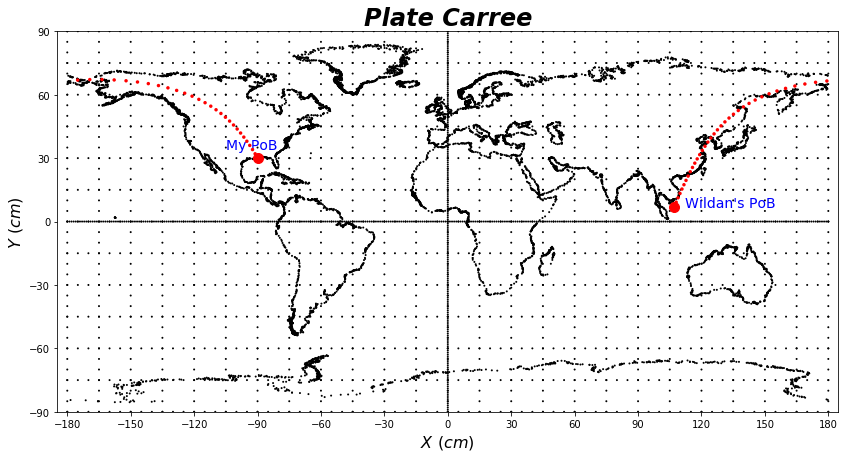

In [43]:
# Plate Carree Mapping Prescription
Xm_PC = lmdK_dd
Ym_PC = psiK_dd
XmW_PC = lmdW_dd
YmW_PC = psiW_dd

# Labels for markers
labels_PC = ['My PoB']
labelsW_PC = ["Wildan's PoB"]

# Defining the plot name
PCn = plt

# Resizing the plot window
PCn.rcParams["figure.figsize"] = (14,7)
PCn.rcParams['axes.spines.right'] = True
PCn.rcParams['axes.spines.top'] = True
PCn.axis('equal')

# Plotting the original locations
PCn.plot(Xm_PC, Ym_PC, 'ro', markersize=10, zorder=5)
PCn.plot(XmW_PC, YmW_PC, 'ro', markersize=10, zorder=5)

# Plotting the coastlines
PCn.scatter(coast_dd['lambda'], coast_dd['psi'], c='k', s=4, edgecolors='none', zorder=2)

# Plotting the gridlines
PCn.scatter(grid_dd['lambda'], grid_dd['psi'], c='k', s=4, edgecolors='none', zorder=3)

# Plotting the path from A to B
PCn.scatter(pathAB['lambda'], pathAB['psi'], c='r', s=12, edgecolors='none', zorder=4)

# Plot title & Axis labels
PCn.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
PCn.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
PCn.title('Plate Carree', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_PC):
    PCn.annotate(txt, (Xm_PC-15, Ym_PC+4), fontsize='14', color='b')
for i, txt in enumerate(labelsW_PC):
    PCn.annotate(txt, (XmW_PC+5, YmW_PC), fontsize='14', color='b')
    
# Tick Mark Labels
PCn.xticks(np.arange(-180, 181, 30))
PCn.yticks(np.arange(-90, 91, 30))
PCn.ylim(-90,90)
PCn.xlim(-180,180)

# Grid
PCn.grid(True, color='white', zorder=1)


-------

## $\blacktriangleright$ Sanson-Flamsteed

###### Plotting Sanson-Flamsteed Map

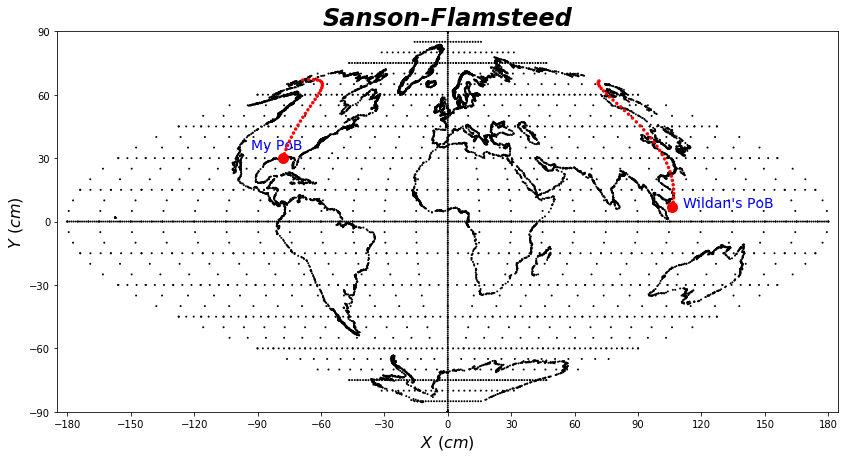

In [44]:
# Sanson-Flamsteed Mapping Prescription
Xm_SF = lmdK_dd * np.cos(psiK_dd*rad)
Ym_SF = psiK_dd
XmW_SF = lmdW_dd * np.cos(psiW_dd*rad)
YmW_SF = psiW_dd

# Labels for markers
labels_SF = ['My PoB']
labelsW_SF = ["Wildan's PoB"]

# Defining the plot name
SFn = plt

# Resizing the plot window
SFn.rcParams["figure.figsize"] = (14,7)
SFn.rcParams['axes.spines.right'] = True
SFn.rcParams['axes.spines.top'] = True
SFn.axis('equal')

# Plotting the original locations
SFn.plot(Xm_SF, Ym_SF, 'ro', markersize=10, zorder=5)
SFn.plot(XmW_SF, YmW_SF, 'ro', markersize=10, zorder=5)

# Plotting the coastlines
SFn.scatter(coast_dd['lambda']*np.cos(coast_dd['psi']*rad), coast_dd['psi'], c='k', s=4, 
            edgecolors='none', zorder=2)

# Plotting the gridlines
SFn.scatter(grid_dd['lambda']*np.cos(grid_dd['psi']*rad), grid_dd['psi'], c='k', s=4, 
            edgecolors='none', zorder=3)

# Plotting the path from A to B
SFn.scatter(pathAB['lambda']*np.cos(pathAB['psi']*rad), pathAB['psi'], c='r', s=12, 
            edgecolors='none', zorder=4)

# Plot title & Axis labels
SFn.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
SFn.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
SFn.title('Sanson-Flamsteed', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_SF):
    SFn.annotate(txt, (Xm_SF-15, Ym_SF+4), fontsize='14', color='b')
for i, txt in enumerate(labelsW_SF):
    SFn.annotate(txt, (XmW_SF+5, YmW_SF), fontsize='14', color='b')

# Tick Mark Labels
SFn.xticks(np.arange(-180, 181, 30))
SFn.yticks(np.arange(-90, 91, 30))
SFn.ylim(-90,90)
SFn.xlim(-180,180)

# Grid
SFn.grid(True, color='white', zorder=1)

## $\blacktriangleright$ Mercator

###### Plotting Mercator Map

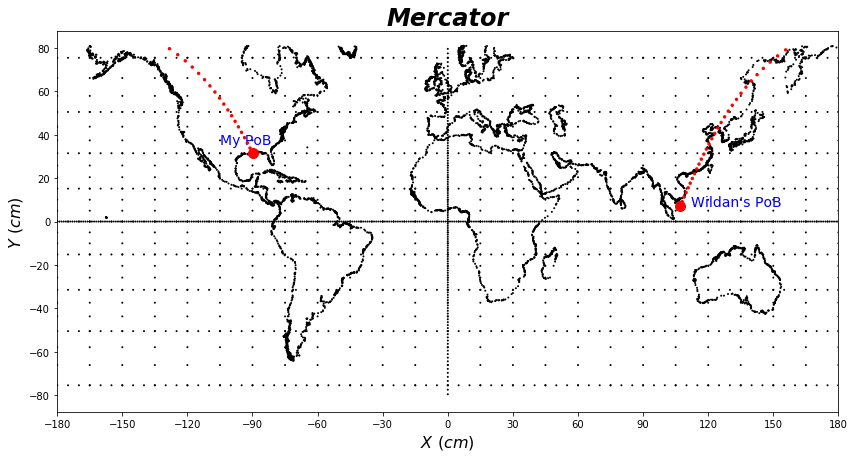

In [45]:
# Applying the Mercator Mapping Prescription to the coordinates
coordsK_M = mercator(coordsK_dd)
coordsW_M = mercator(coordsW_dd)

# Mercator mapping prescription
Xm_M = coordsK_M['lambda']
Ym_M = coordsK_M['psi']
XmW_M = coordsW_M['lambda']
YmW_M = coordsW_M['psi']

# Labels for markers
labels_M = ['My PoB']
labelsW_M = ["Wildan's PoB"]

# Defining the plot name
MCn = plt

# Resizing the plot window
MCn.rcParams["figure.figsize"] = (14,7)
MCn.rcParams['axes.spines.right'] = True
MCn.rcParams['axes.spines.top'] = True
MCn.axis('equal')

# Plotting the original locations
MCn.plot(Xm_M, Ym_M, 'ro', markersize=10, zorder=5)
MCn.plot(XmW_M, YmW_M, 'ro', markersize=10, zorder=5)

# Applying the Mercator Mapping Prescription to the coastlines
coast_M = mercator(coast_dd)

# Plotting the coastlines
MCn.scatter(coast_M['lambda'], coast_M['psi'], c='k', s=4, edgecolors='none', zorder=2)

# Applying the Mercator Mapping Prescription to the gridlines
grid_M = mercator(grid_dd)

# Plotting the gridlines
MCn.scatter(grid_M['lambda'], grid_M['psi'], c='k', s=4, edgecolors='none', zorder=3)

# Applying the Mercator Mapping Prescription to the path from A to B
pathAB_M = mercator(pathAB)

# Plotting the path from A to B
MCn.scatter(pathAB_M['lambda'], pathAB_M['psi'], c='r', s=12, edgecolors='none', zorder=4)

# Plot title & Axis labels
MCn.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
MCn.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
MCn.title('Mercator', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_M):
    MCn.annotate(txt, (Xm_M-15, Ym_M+4), fontsize='14', color='b')
for i, txt in enumerate(labelsW_M):
    MCn.annotate(txt, (XmW_M+5, YmW_M), fontsize='14', color='b')

# Tick Mark Labels
MCn.xticks(np.arange(-180, 181, 30))
MCn.yticks(np.arange(-80, 81, 20))
MCn.ylim(-80,80)
MCn.xlim(-180,180)

# Grid
MCn.grid(True, color='white', zorder=1)

______

## $\blacktriangleright$ Transverse Plate Carree

###### Plotting Transverse Plate Carree Map

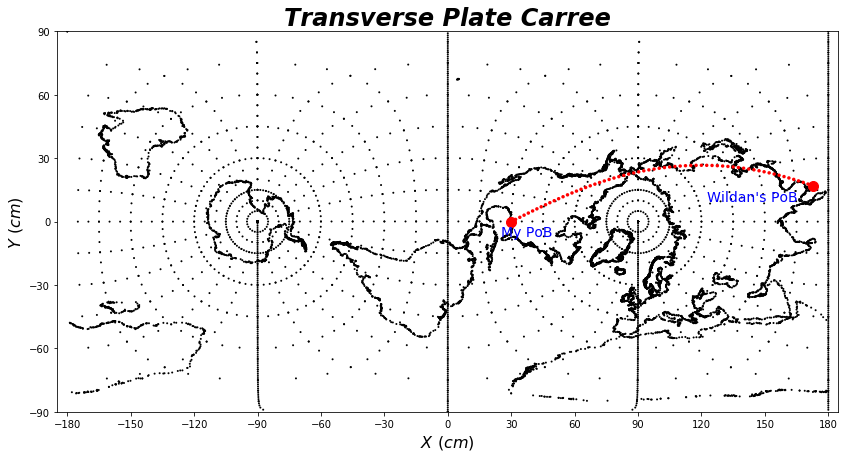

In [46]:
# Transverse Plate Carree Mapping Prescription
XmT_PC = lmdK_ddT
YmT_PC = psiK_ddT
XmWT_PC = lmdW_ddT
YmWT_PC = psiW_ddT

# Labels for markers
labels_PC = ['My PoB']
labelsW_PC = ["Wildan's PoB"]

# Defining the plot name
PCt = plt

# Resizing the plot window
PCt.rcParams["figure.figsize"] = (14,7)
PCt.rcParams['axes.spines.right'] = True
PCt.rcParams['axes.spines.top'] = True
PCt.axis('equal')

# Plotting the original locations
PCt.plot(XmT_PC, YmT_PC, 'ro', markersize=10, zorder=5)
PCt.plot(XmWT_PC, YmWT_PC, 'ro', markersize=10, zorder=5)

# Plotting the coastlines
PCt.scatter(coast_ddT['lambda'], coast_ddT['psi'], c='k', s=4, edgecolors='none', zorder=2)

# Plotting the gridlines
PCt.scatter(grid_ddT['lambda'], grid_ddT['psi'], c='k', s=4, edgecolors='none', zorder=3)

# Plotting the gridlines
PCt.scatter(pathABT['lambda'], pathABT['psi'], c='r', s=12, edgecolors='none', zorder=4)

# Plot title & Axis labels
PCt.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
PCt.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
PCt.title('Transverse Plate Carree', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_PC):
    PCt.annotate(txt, (XmT_PC-5, YmT_PC-7), fontsize='14', color='b', zorder=6)
for i, txt in enumerate(labelsW_PC):
    PCt.annotate(txt, (XmWT_PC-50, YmWT_PC-7), fontsize='14', color='b', zorder=6)

# Tick Mark Labels
PCt.xticks(np.arange(-180, 181, 30))
PCt.yticks(np.arange(-90, 91, 30))
PCt.ylim(-90,90)
PCt.xlim(-180,180)

# Grid
PCt.grid(True, color='white', zorder=1)

## $\blacktriangleright$ Transverse Sanson-Flamsteed

###### Plotting Transverse Sanson-Flamsteed Map

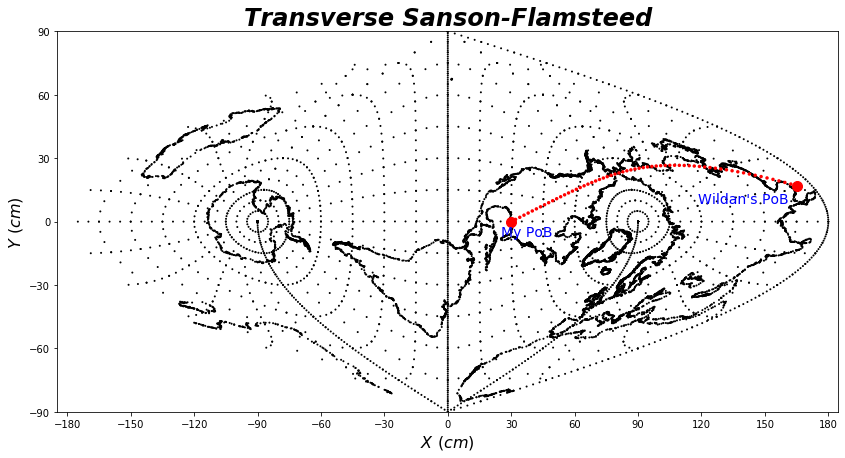

In [47]:
# Transverse Plate Carree Mapping Prescription
XmT_SF = lmdK_ddT * np.cos(psiK_ddT*rad)
YmT_SF = psiK_ddT
XmWT_SF = lmdW_ddT * np.cos(psiW_ddT*rad)
YmWT_SF = psiW_ddT

# Labels for markers
labels_SF = ['My PoB']
labelsW_SF = ["Wildan's PoB"]

# Defining the plot name
SFt = plt

# Resizing the plot window
SFt.rcParams["figure.figsize"] = (14,7)
SFt.rcParams['axes.spines.right'] = True
SFt.rcParams['axes.spines.top'] = True
SFt.axis('equal')

# Plotting the original locations
SFt.plot(XmT_SF, YmT_SF, 'ro', markersize=10, zorder=5)
SFt.plot(XmWT_SF, YmWT_SF, 'ro', markersize=10, zorder=5)

# Plotting the coastlines
SFt.scatter(coast_ddT['lambda']*np.cos(coast_ddT['psi']*rad), coast_ddT['psi'], c='k', s=4, 
            edgecolors='none', zorder=2)

# Plotting the gridlines
SFt.scatter(grid_ddT['lambda']*np.cos(grid_ddT['psi']*rad), grid_ddT['psi'], c='k', s=4, 
            edgecolors='none', zorder=3)

# Plotting the pathway from A to B
SFt.scatter(pathABT['lambda']*np.cos(pathABT['psi']*rad), pathABT['psi'], c='r', s=12, 
            edgecolors='none', zorder=4)

# Plot title & Axis labels
SFt.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
SFt.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
SFt.title('Transverse Sanson-Flamsteed', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_SF):
    SFt.annotate(txt, (XmT_SF-5, YmT_SF-7), fontsize='14', color='b', zorder=6)
for i, txt in enumerate(labelsW_SF):
    SFt.annotate(txt, (XmWT_SF-47, YmWT_SF-8), fontsize='14', color='b', zorder=6)

# Tick Mark Labels
SFt.xticks(np.arange(-180, 181, 30))
SFt.yticks(np.arange(-90, 91, 30))
SFt.ylim(-90,90)
SFt.xlim(-180,180)

# Grid
SFt.grid(True, color='white', zorder=1)

## $\blacktriangleright$ Transverse Mercator

###### Plotting Transverse Mercator Map

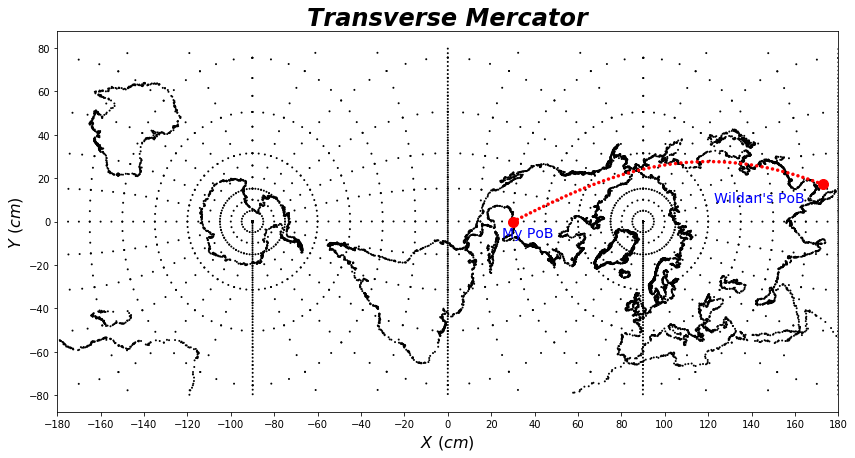

In [48]:
# Applying the Mercator Mapping Prescription to the coordinates
coordsK_MT = mercator(coordsK_ddT)
coordsW_MT = mercator(coordsW_ddT)

# Transverse Mercator Mapping Prescription
XmT_M = coordsK_MT['lambda']
YmT_M = coordsK_MT['psi']
XmWT_M = coordsW_MT['lambda']
YmWT_M = coordsW_MT['psi']

# Labels for markers
labels_MT = ['My PoB']
labelsW_MT = ["Wildan's PoB"]

# Defining the plot name
MCt = plt

# Resizing the plot window
MCt.rcParams["figure.figsize"] = (14,7)
MCt.rcParams['axes.spines.right'] = True
MCt.rcParams['axes.spines.top'] = True
MCt.axis('equal')

# Plotting the original locations
MCt.plot(XmT_M, YmT_M, 'ro', markersize=10, zorder=5)
MCt.plot(XmWT_M, YmWT_M, 'ro', markersize=10, zorder=5)

# Applying the Mercator Mapping Prescription to the coastlines
coast_MT = mercator(coast_ddT)

# Plotting the coastlines
MCt.scatter(coast_MT['lambda'], coast_MT['psi'], c='k', s=4, edgecolors='none', zorder=2)

# Applying the Mercator Mapping Prescription to the gridlines
grid_MT = mercator(grid_ddT)

# Plotting the gridlines
MCt.scatter(grid_MT['lambda'], grid_MT['psi'], c='k', s=4, edgecolors='none', zorder=3)

# Applying the Mercator Mapping Prescription to the gridlines
pathAB_MT = mercator(pathABT)

# Plotting the gridlines
MCt.scatter(pathAB_MT['lambda'], pathAB_MT['psi'], c='r', s=12, edgecolors='none', zorder=4)

# Plot title & Axis labels
MCt.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
MCt.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
MCt.title('Transverse Mercator', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_MT):
    MCt.annotate(txt, (XmT_M-5, YmT_M-7), fontsize='14', color='b', zorder=6)
for i, txt in enumerate(labelsW_MT):
    MCt.annotate(txt, (XmWT_M-50, YmWT_M-8), fontsize='14', color='b', zorder=6)

# Tick Mark Labels
MCt.xticks(np.arange(-180, 181, 20))
MCt.yticks(np.arange(-80, 81, 20))
MCt.ylim(-80,80)
MCt.xlim(-180,180)

# Grid
MCt.grid(True, color='white', zorder=1)

______

## $\blacktriangleright$ Stereographic

###### Plotting Stereographic Map

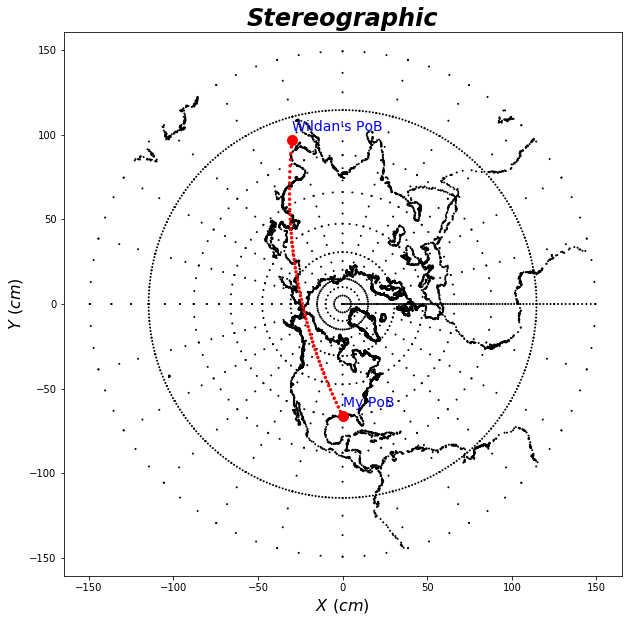

In [49]:
# Applying the Stereographic Mapping Prescription to the coordinates
coordsK_ST = stereo(coordsK_dd, 0)
coordsW_ST = stereo(coordsW_dd, 0)

# Stereographic mapping prescription
Xm_ST = coordsK_ST['lambda']
Ym_ST = coordsK_ST['psi']
XmW_ST = coordsW_ST['lambda']
YmW_ST = coordsW_ST['psi']

# Labels for markers
labels_ST = ['My PoB']
labelsW_ST = ["Wildan's PoB"]

# Defining the plot name
STn = plt

# Resizing the plot window
STn.rcParams["figure.figsize"] = (10,10)
STn.rcParams['axes.spines.right'] = True
STn.rcParams['axes.spines.top'] = True
STn.axis('equal')

# Plotting the original locations
STn.plot(Xm_ST, Ym_ST, 'ro', markersize=10, zorder=5)
STn.plot(XmW_ST, YmW_ST, 'ro', markersize=10, zorder=5)

# Applying the Stereographic Mapping Prescription to the coastlines
coast_ST = stereo(coast_dd, 0)

# Plotting the coastlines
STn.scatter(coast_ST['lambda'], coast_ST['psi'], c='k', s=4, edgecolors='none', zorder=2)

# Applying the Stereographic Mapping Prescription to the gridlines
grid_ST = stereo(grid_dd, 0)

# Plotting the gridlines
STn.scatter(grid_ST['lambda'], grid_ST['psi'], c='k', s=4, edgecolors='none', zorder=3)

# Applying the Stereographic Mapping Prescription to the gridlines
pathAB_ST = stereo(pathAB, 0)

# Plotting the gridlines
STn.scatter(pathAB_ST['lambda'], pathAB_ST['psi'], c='r', s=12, edgecolors='none', zorder=4)


# Plot title & Axis labels
STn.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
STn.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
STn.title('Stereographic', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_ST):
    STn.annotate(txt, (Xm_ST, Ym_ST+5), fontsize='14', color='b', zorder=6)
for i, txt in enumerate(labelsW_ST):
    STn.annotate(txt, (XmW_ST, YmW_ST+5), fontsize='14', color='b', zorder=6)
    
# Grid
STn.grid(True, color='white', zorder=1)

______

## $\blacktriangleright$ Oblique Stereographic

###### Plotting Oblique Stereographic Map

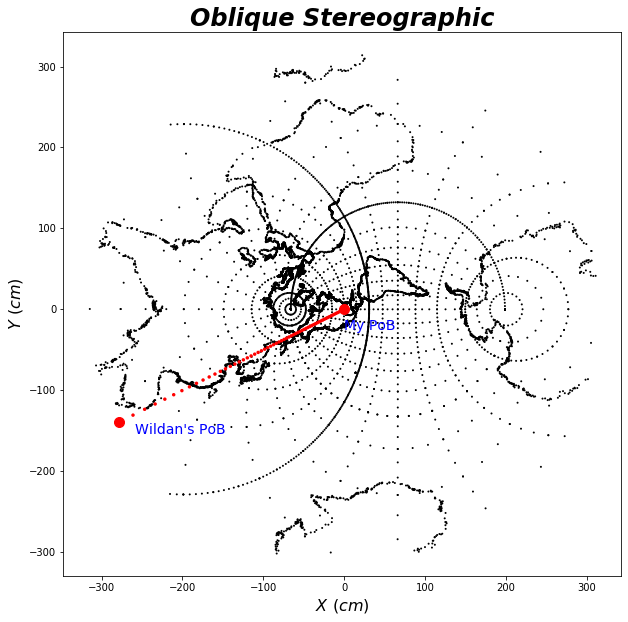

In [50]:
# Applying the Stereographic Mapping Prescription to the coordinates
coordsK_OST = stereo(coordsK_ddO, 1)
coordsW_OST = stereo(coordsW_ddO, 1)
coast_OST = stereo(coast_ddO, 1)
grid_OST = stereo(grid_ddO, 1)
pathAB_OST = stereo(pathABO, 1)

# Stereographic mapping prescription
Xm_OST = coordsK_OST['lambda']
Ym_OST = coordsK_OST['psi']
XmW_OST = coordsW_OST['lambda']
YmW_OST = coordsW_OST['psi']

# Labels for markers
labels_OST = ['My PoB']
labelsW_OST = ["Wildan's PoB"]

# Defining the plot name
OSTn = plt

# Resizing the plot window
OSTn.rcParams["figure.figsize"] = (10,10)
OSTn.rcParams['axes.spines.right'] = True
OSTn.rcParams['axes.spines.top'] = True
OSTn.axis('equal')

# Plotting the original locations
OSTn.plot(Xm_OST, Ym_OST, 'ro', markersize=10, zorder=5)
OSTn.plot(XmW_OST, YmW_OST, 'ro', markersize=10, zorder=5)

# Plotting the coastlines
OSTn.scatter(coast_OST['lambda'], coast_OST['psi'], c='k', s=4, edgecolors='none', zorder=2)

# Plotting the gridlines
OSTn.scatter(grid_OST['lambda'], grid_OST['psi'], c='k', s=4, edgecolors='none', zorder=3)

# Plotting the gridlines
OSTn.scatter(pathAB_OST['lambda'], pathAB_OST['psi'], c='r', s=12, edgecolors='none', zorder=3)

# Plot title & Axis labels
OSTn.xlabel('$X$ $(cm)$', fontsize='16', fontweight='bold')
OSTn.ylabel('$Y$ $(cm)$', fontsize='16', fontweight='bold')
OSTn.title('Oblique Stereographic', fontsize='24', fontweight='bold', style='italic')

# Adding labels to the markers
for i, txt in enumerate(labels_OST):
    OSTn.annotate(txt, (Xm_OST, Ym_OST-25), fontsize='14', color='b', zorder=6)
for i, txt in enumerate(labelsW_OST):
    OSTn.annotate(txt, (XmW_OST+20, YmW_OST-15), fontsize='14', color='b', zorder=6)

# Grid
OSTn.grid(True, color='white', zorder=1)

______

# <span style="color:blue">*PART 4 - Discussion*<span>

The shortest path from my place of birth in Louisiana to Wildan's place of birth in Indonesia is approximately 15522 km along the great circle connecting our two locations. The path travels NW from Louisiana towards Alaska, then follows the coastline down Asia's eastern edge before ultimately arriving in Indonesia. My initial hypothesis was that the shortest path would travel West across the United State and the Pacific Ocean with a slight arc towards the North Pole, but eventually making a turn south since Wildan's latitude is closer to the equator than mine. I was very surprised to see that the shortest path was as close to the North Pole as it was, so I checked Google maps to see what it said the shortest path was and they were identical. I once flew from Bangkok to Los Angeles with a layover in Tokyo, and the flight path was very similar to this. I always assumed that we followed the coastline like that in case there was an emergency and we needed to land, but now I know it is really because we were following the shortest path! 
The Plate Carree mapping prescription is the first map I plotted the path on and, at first glance, I thought maybe I did something incorrectly because the points which are equidistant from each other grew farther apart as the path traveled higher in latitude. I quickly realized this was correct, though, and that it was just the result of the mapping prescription.
After plotting the Sanson-Flamsteed mapping prescription, I again thought maybe I had done something wrong, but then I could tell that it was the same path as the Plate Carree, just from a different perspective. This map was probably the most difficult to interpret, but that is most likely a result of where the path is located. If the path had spanned from South America to Africa or Europe, the interpretation would be far less challenging.
The Mercator mapping prescription visually resembled the Platte Carree, as it usual does at first glance, but the path appears to travel much higher into Alaska with the Mercator map. It would make sense that this would be a result of the mapping prescription since the latitudes approach infinity as you travel farther and farther north. Also, things are much more stretched near the poles with the Platte Carree mapping prescription, so this probably helps creat the illusion of a lower trajectory.
The Transverse Plate Carree mapping prescription is centered over the poles, so this map provides a much better perspective of the path behavior since the path travels so close to the North Pole. This perspective further helps to dismiss my initial hypothesis because the path is clearly shorter than traveling along a parallel line.  
The path behavior doesn't seem to change very much between the Transverse Plate Carree and the Transverse Sanson-Flamsteed prescription, however, the warped perspective of the Transverse Sanson-Flamsteed almost gives the illusion that the line is 3-dimensional. It looks at though it is coming off of the page in the middle, connected only at the PoBs.  The points making up the line appear to be more bunched up in the middle than near the ends.
Much like the Transverse Plate Carree, the Transverse Mercator mapping prescription provides a better perspective over the poles. The path in the Transverse Mercator is very similar to the path in the Transverse Plate Carree, but the line seems to be slightly straighter in the Transverse Mercator. Both the Transverse Plate Carree and the Transverse Mercator appear to have little affect on the spacing of the points making up the line.
The path line in the Stereographic mapping prescrition is even straighter than it was in the Transverse Mercator. This mapping prescription does a very good job illustrating the trajectory of the line path, and the points making up the line do not appear to spread apart nearly as much as the other mapping prescriptions.
The Oblique Steregraphic mapping prescription shows the path line as a perfectly straight line. This is due to the mapping prescription treating our place of birth as the new North Pole, so the path to any point on Earth will be a straight line along a great circle. For this unique quality, I believe the Oblique Stereographic mapping prescription is the most effective way to illustrate the path as a shortest distance between two points. The points making up the line ar very densely compact near my PoB, though, and very dispersed near Wildan's PoB. This is not only one of the downsides of this mapping prescription, but it also proved to be one of the many challenges I faced when creating this map.  My original stereographic function had limited all the data to -15 degrees latitude and north, but after applying the oblique function to Wildan's PoB, he was well beyond that threshold. To fix this without compromising the normal sterographic map, I had to write an if/then function to apply different limits.